In [3]:
using Pkg
Pkg.add("Plots", io=devnull)
# Pkg.update(io=devnull)
using Plots
using Plots.PlotMeasures

In [4]:
struct Result
    net :: String
    spec :: String
    status :: String
    runtime :: Int64
    num_propagation :: Int64
    num_input_splits :: Int64
    num_neuron_splits :: Int64
    initial_δ_bound :: Float64
    final_δ_bound :: Float64
end

struct Results
    verifier_name :: String
    results :: Vector{Result}
end

In [5]:
function read_results(name::String, csv_dir::String; sort_func=nothing)
    results = Result[]
    open(csv_dir, "r") do f
        while !eof(f)
            line = split(readline(f), ",")
            net = replace(line[1], " " => "")
            spec = replace(line[2], " " => "")
            status = replace(line[3], " " => "")
            runtime = parse(Int64, string(line[4]))
            num_propagation = parse(Int64, string(line[5]))
            num_input_splits = parse(Int64, string(line[6]))
            num_neuron_splits = parse(Int64, string(line[7]))
            initial_δ_bound = parse(Float64, string(line[8]))
            final_δ_bound = parse(Float64, string(line[9]))
            push!(results, Result(net, spec, status, runtime, num_propagation, num_input_splits, num_neuron_splits, initial_δ_bound, final_δ_bound))
        end
    end
    if !isnothing(sort_func)
        sort!(results, by=sort_func)
    end
    return Results(name, results)
end

read_results (generic function with 1 method)

In [7]:
cur_dir = @__DIR__
exp_final_dir = joinpath(cur_dir, "experiments_final")

acas_name = "acas-0.5"
mnist_name = "mnist-1.0"

results_name = "results.csv"

verydiff_name = "VeryDiff"
verydiff_acas_path = joinpath(exp_final_dir, verydiff_name, acas_name, results_name)
verydiff_mnist_path = joinpath(exp_final_dir, verydiff_name, mnist_name, results_name)

# heuristic_variants = [["ZB" "ZU" "DB" "DU"], ["Alt" "Base" "Input" "DiffZono" "Input-DiffZono"]]
heuristic_variants = [["ZU" "DU"], ["Base" "Input-DiffZono"]]

names = ["DeepSplit", "ZonoContract", "ZonoContractInter", "ZonoContractPre", "ZonoContractPost"]
for v in heuristic_variants
    names = reduce(vcat, [d * "-" .* v for d in names])
end

acas_paths = Tuple{String, String}[]
mnist_paths = Tuple{String, String}[]
for name in names
    dir = joinpath(exp_final_dir, name)
    push!(acas_paths, (name, joinpath(dir, acas_name, results_name)))
    # push!(mnist_paths, (name, joinpath(dir, mnist_name, results_name)))
end

push!(acas_paths, (verydiff_name, verydiff_acas_path))
# push!(mnist_paths, (verydiff_name, verydiff_mnist_path))

println("...")

...


In [8]:
sort_func_solved = r -> r.runtime
sort_func_unsolved = r -> (r.initial_δ_bound - r.final_δ_bound) / (r.initial_δ_bound - 0.5)

acas_results = [read_results(n, p) for (n, p) in acas_paths]
# mnist_results = [read_results(n, p; sort_func=sort_func) for (n, p) in mnist_paths]

acas_solved, acas_unsolved = Results[], Results[]
# mnist_solved, mnist_unsolved = Results[], Results[]

for results in acas_results
    mask = map(r -> r.status != "UNKNOWN", results.results)
    solved = results.results[mask]
    unsolved = results.results[.!mask]
    sort!(solved, by=sort_func_solved)
    sort!(unsolved, by=sort_func_unsolved, rev=true)
    push!(acas_solved, Results(results.verifier_name, solved))
    push!(acas_unsolved, Results(results.verifier_name, unsolved))
end

# for res in acas_unsolved
#     for inst in res.results
#         @assert inst.runtime / 1e9 >= 120.0
#     end
# end

# for results in mnist_results
    # mask = map(r -> r.status != "UNKNOWN", results.results)
    # solved = results.results[mask]
    # unsolved = results.results[.!mask]
    # sort!(solved, by=sort_func_solved)
    # sort!(solved, by=sort_func_unsolved)
    # push!(mnist_solved, Results(results.verifier_name, solved))
    # push!(mnist_unsolved, Results(results.verifier_name, unsolved))
# end


In [9]:
x_acas_solved = map(r -> 1:size(r.results, 1), acas_solved)
y_acas_solved = map(acas_solved) do r
    return map(r.results) do r
        return r.runtime / 1e9
    end
end

# x_mnist_solved = map(r -> 1:size(r.results, 1), mnist_solved)
# y_mnist_solved = map(mnist_solved) do r
#     return map(r.results) do r
#         return r.runtime / 1e9
#     end 
# end


21-element Vector{Vector{Float64}}:
 [0.000506523, 0.00057838, 0.000588579, 0.001460873, 0.001475828, 0.001515034, 0.001674563, 0.001684837, 0.001729971, 0.001746858  …  0.001935849, 0.001975002, 0.002097492, 0.002141386, 0.002904024, 0.089699542, 0.145608997, 0.765413608, 1.954987538, 33.548336316]
 [0.000520956, 0.000590674, 0.000596608, 0.001510068, 0.001534606, 0.001553351, 0.001661656, 0.001700731, 0.001797977, 0.001817665  …  0.002034979, 0.002096185, 0.00215354, 0.010957885, 0.057180505, 0.103957008, 0.276157817, 0.466301163, 1.020086379, 25.280492565]
 [0.00053589, 0.000577811, 0.000578893, 0.001543122, 0.00159395, 0.001717113, 0.001746488, 0.001818949, 0.001876939, 0.002037985  …  0.002241577, 0.003308086, 0.003346152, 0.020150155, 0.065939028, 0.097725494, 0.364938561, 0.609075249, 0.964584465, 1.083555426]
 [0.000529278, 0.000608921, 0.000632509, 0.00148335, 0.001510923, 0.001674118, 0.001737477, 0.001792737, 0.001810639, 0.001967808, 0.00197631, 0.001985476, 0.001996784, 0.

In [20]:
verydiff_rgx = r"VeryDiff"
deepsplit_rgx = r"DeepSplit"
zonocontract_rgx = r"ZonoContract-(ZB|ZU|DB|DU)"
zonocontract_pre_rgx = r"ZonoContractPre"
zonocontract_post_rgx = r"ZonoContractPost"
zonocontract_inter_rgx = r"ZonoContractInter"
alt_rgx = r"((ZB|ZU|DB|DU)\-Alt$)"
base_rgx = r"((ZB|ZU|DB|DU)\-Base$)"
input_rgx = r"((ZB|ZU|DB|DU)\-Input$)"
diffzono_rgx = r"((ZB|ZU|DB|DU)\-DiffZono$)"
input_diffzono_rgx = r"((ZB|ZU|DB|DU)\-Input\-DiffZono$)"

config_match_rgx = (res, rgx) -> !isnothing(findfirst(rgx, res.verifier_name))
config_match = (res, rgxs) -> all(map(rgx -> config_match_rgx(res, rgx), rgxs))
filter_indices = (res, rgxs) -> filter(i -> config_match(res[i], rgxs), 1:size(res, 1))

# acas_indices = rgxs -> filter_indices(acas_solved, rgxs)
# mnist_indices = rgxs -> filter_indices(mnist_solved, rgxs)

#52 (generic function with 1 method)

In [21]:
verydiff_acas_results = acas_results[filter_indices(acas_results, [verydiff_rgx])][1]

for res in acas_results
    if res.verifier_name == verydiff_acas_results.verifier_name
        continue
    end
    for i in 1:100
        s₁, s₂ = verydiff_acas_results.results[i].status, res.results[i].status
        p₁, p₂ = verydiff_acas_results.results[i].spec, res.results[i].spec
        @assert s₁ == s₂ || s₁ == "UNKNOWN" || s₂ == "UNKNOWN" "(status₁, prop₁): ($s₁, $p₁), (status₂, prop₂): ($s₂, $p₂)"
    end
end


In [22]:
verydiff_config = ("VeryDiff", [verydiff_rgx])

base_configs = [
    ("LP-Base", [deepsplit_rgx, base_rgx]), 
    ("ZC-Base", [zonocontract_rgx, base_rgx]),
    ("ZC-Pre-Base", [zonocontract_pre_rgx, base_rgx]),
    ("ZC-Post-Base", [zonocontract_post_rgx, base_rgx]),
    ("ZC-Inter-Base", [zonocontract_inter_rgx, base_rgx]),
]

input_diffzono_configs = [
    ("LP-Input-DiffZono", [deepsplit_rgx, input_diffzono_rgx]),
    ("ZC-Input-DiffZono", [zonocontract_rgx, input_diffzono_rgx]),
    ("ZC-Pre-Input-DiffZono", [zonocontract_pre_rgx, input_diffzono_rgx]),
    ("ZC-Post-Input-DiffZono", [zonocontract_post_rgx, input_diffzono_rgx]),
    ("ZC-Inter-Input-DiffZono", [zonocontract_inter_rgx, input_diffzono_rgx]),
]


5-element Vector{Tuple{String, Vector{Regex}}}:
 ("LP-Input-DiffZono", [r"DeepSplit", r"((ZB|ZU|DB|DU)\-Input\-DiffZono$)"])
 ("ZC-Input-DiffZono", [r"ZonoContract-(ZB|ZU|DB|DU)", r"((ZB|ZU|DB|DU)\-Input\-DiffZono$)"])
 ("ZC-Pre-Input-DiffZono", [r"ZonoContractPre", r"((ZB|ZU|DB|DU)\-Input\-DiffZono$)"])
 ("ZC-Post-Input-DiffZono", [r"ZonoContractPost", r"((ZB|ZU|DB|DU)\-Input\-DiffZono$)"])
 ("ZC-Inter-Input-DiffZono", [r"ZonoContractInter", r"((ZB|ZU|DB|DU)\-Input\-DiffZono$)"])

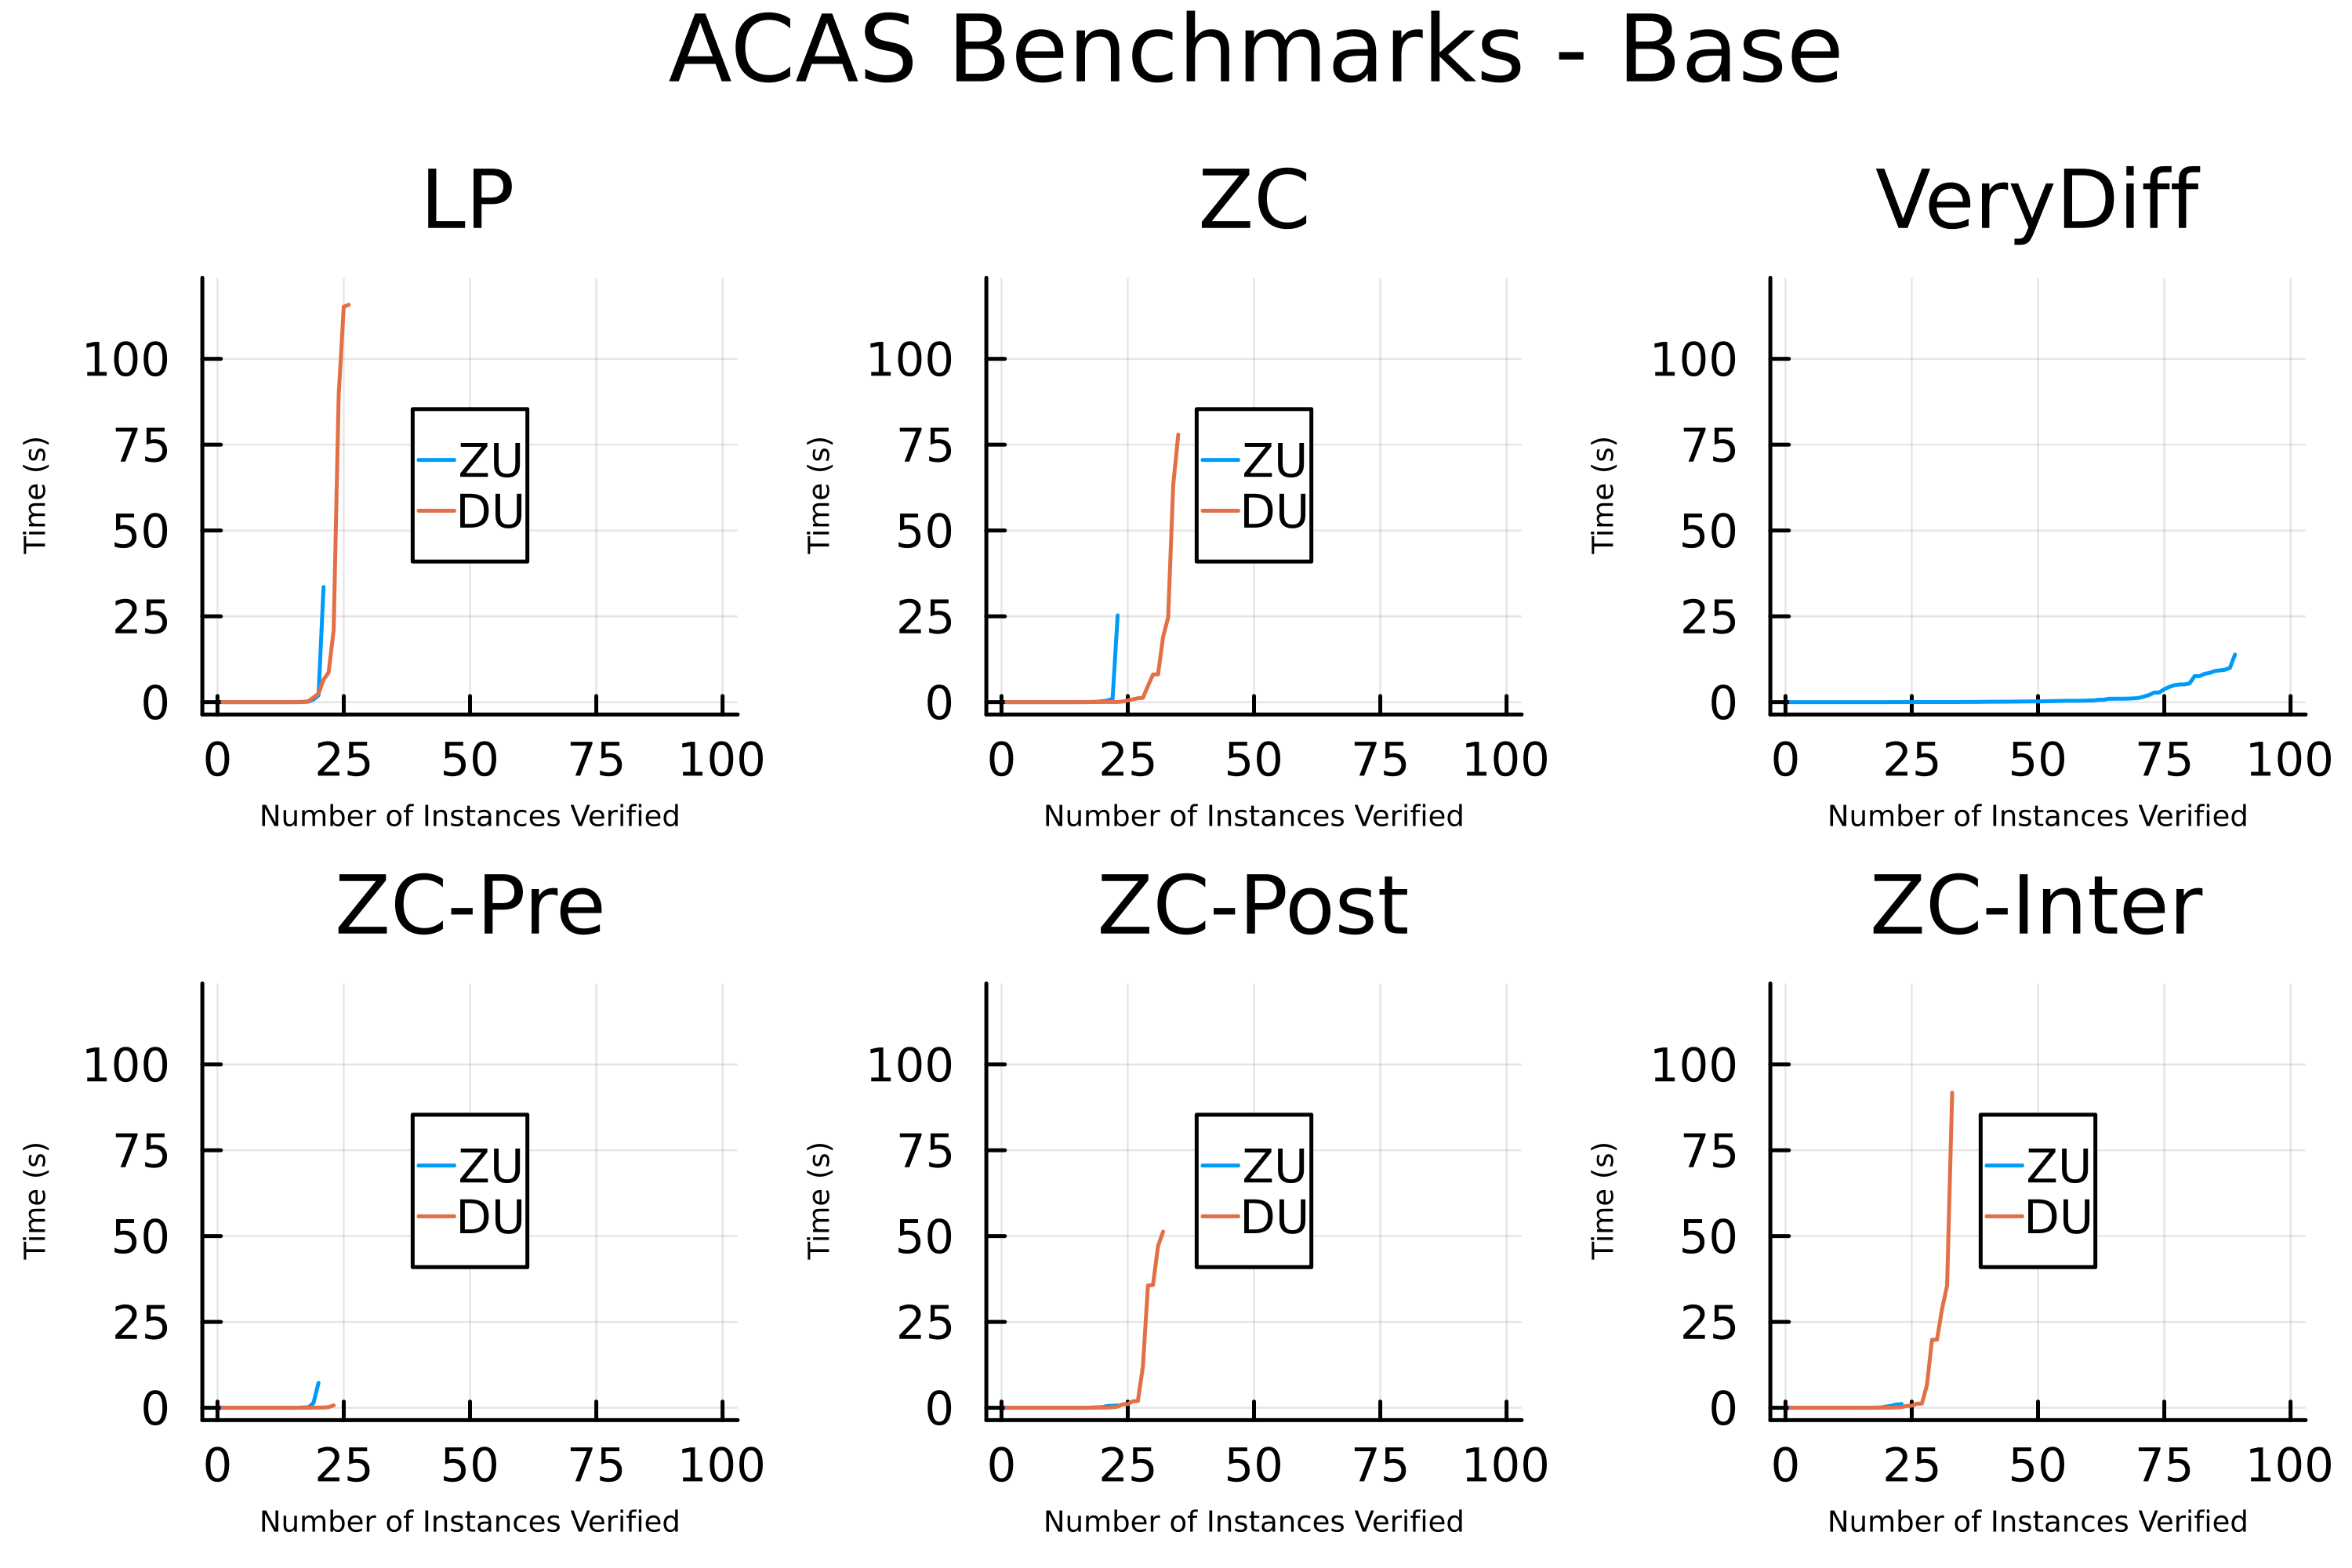

In [25]:
num_configs = size(base_configs, 1) + 1

p = plot(dpi=500, xlims=(0, 100), ylims=(0, 120), widen=true, xguidefontsize=5, yguidefontsize=5, legend=:legend; layout=num_configs)
xlabel!("Number of Instances Verified")
ylabel!("Time (s)")

name, rgxs = verydiff_config
indices = filter_indices(acas_solved, rgxs)
plot!(p, x_acas_solved[indices], y_acas_solved[indices], title=name, label=nothing, subplot=3)

for (i, (name, rgxs)) in enumerate(base_configs)
    indices = filter_indices(acas_solved, rgxs)
    plot!(p, x_acas_solved[indices], y_acas_solved[indices], title=replace(name, "-Base" => ""), label=["ZU" "DU"], subplot=(i + i ÷ 3))
end

plot!(p, plot_title="ACAS Benchmarks - Base", plot_titlevspan=0.1)

savefig(p, "acas_benchmarks_base.png")

p

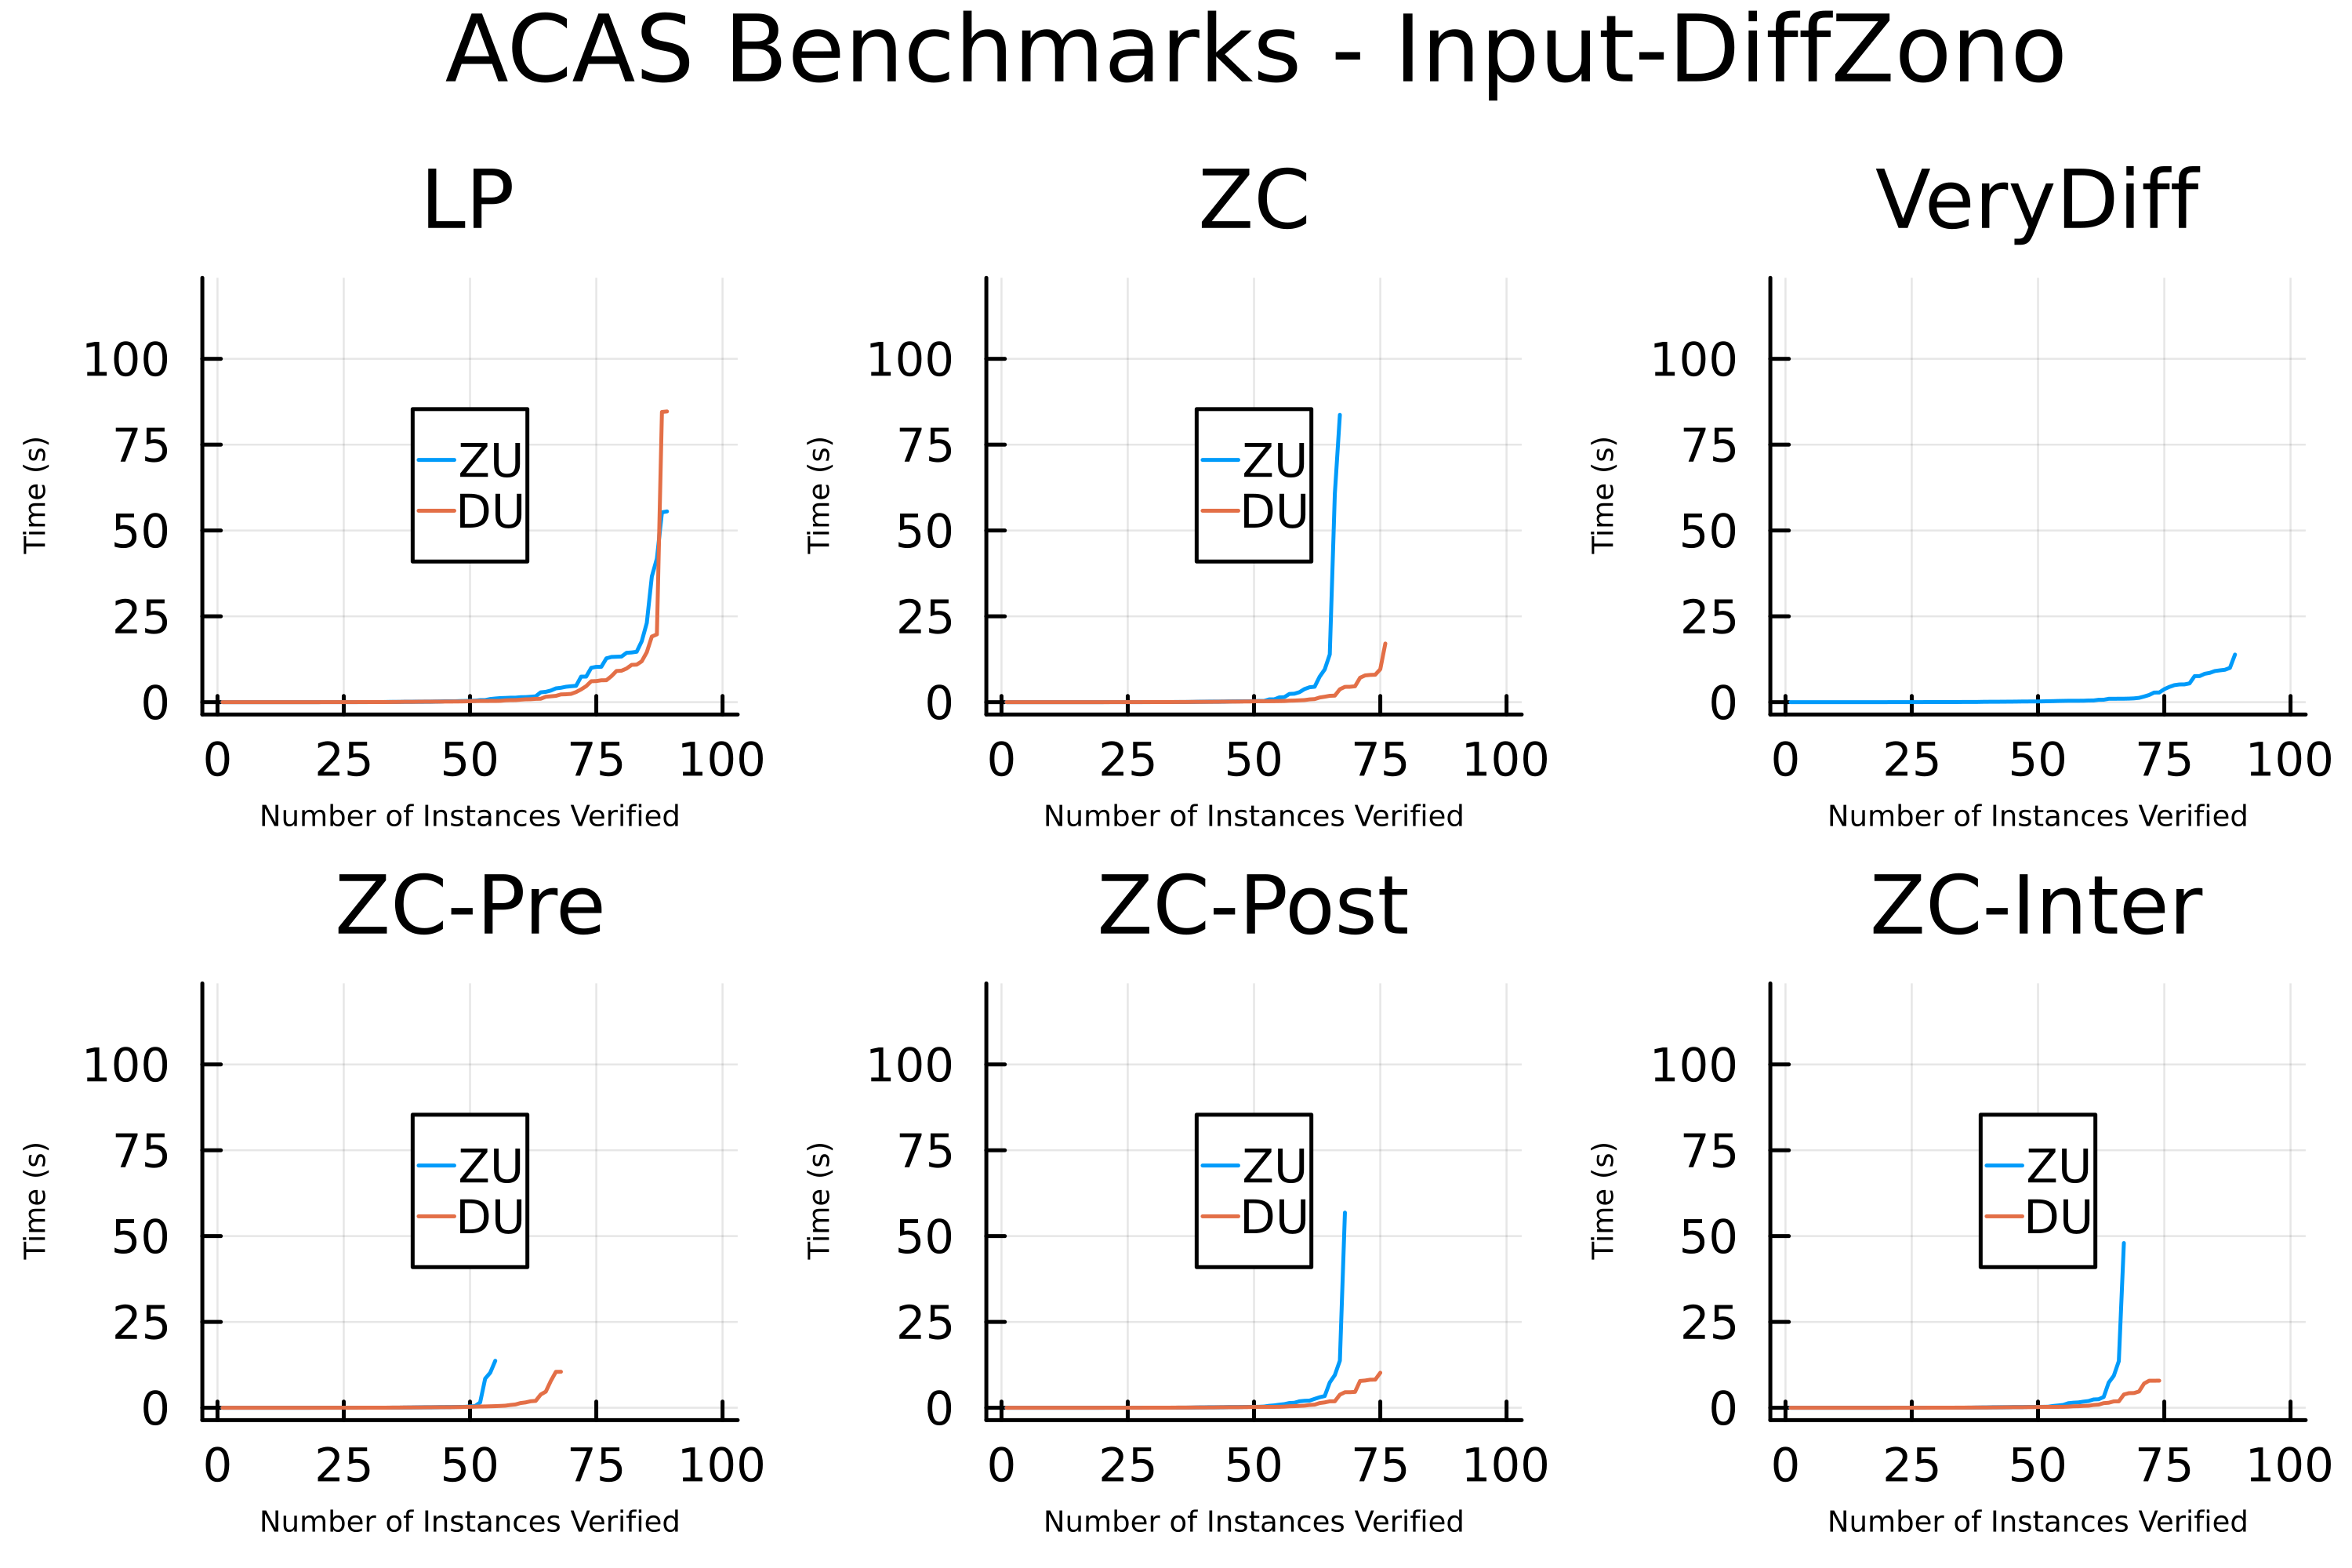

In [24]:
num_configs = size(input_diffzono_configs, 1) + 1

p = plot(dpi=500, xlims=(0, 100), ylims=(0, 120), widen=true, xguidefontsize=5, yguidefontsize=5, legend=:legend; layout=num_configs)
xlabel!("Number of Instances Verified")
ylabel!("Time (s)")

name, rgxs = verydiff_config
indices = filter_indices(acas_solved, rgxs)
plot!(p, x_acas_solved[indices], y_acas_solved[indices], title=name, label=nothing, subplot=3)

for (i, (name, rgxs)) in enumerate(input_diffzono_configs)
    indices = filter_indices(acas_solved, rgxs)
    plot!(p, x_acas_solved[indices], y_acas_solved[indices], title=replace(name, "-Input-DiffZono" => ""), label=["ZU" "DU"], subplot=(i + i ÷ 3))
end

plot!(p, plot_title="ACAS Benchmarks - Input-DiffZono", plot_titlevspan=0.1)

savefig(p, "acas_benchmarks_input_diffzono.png")

p

In [26]:
x_acas_unsolved = map(r -> 1:size(r.results, 1), acas_unsolved)
y_acas_unsolved = map(acas_unsolved) do r
    return map(r.results) do r
        return (r.initial_δ_bound - r.final_δ_bound) / (r.initial_δ_bound - 0.5)
    end
end

# x_mnist_unsolved = map(r -> 1:size(r.results, 1), mnist_unsolved)
# y_mnist_unsolved = map(mnist_unsolved) do r
#     return map(r.results) do r
        # return (r.initial_δ_bound - r.final_δ_bound) / (r.initial_δ_bound - 0.5)
#     end 
# end

21-element Vector{Vector{Float64}}:
 [0.9800524087733011, 0.8134399701782377, 0.7633394947792019, 0.4954326839739521, 0.38428284696774634, 0.27445189312325124, 0.2352373002241018, 0.2224303970461237, 0.18535409023495783, 0.10660287440977985  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.9937191229884861, 0.9823174312912027, 0.9714076797957907, 0.9433401032109229, 0.9107683272367668, 0.8964131203649979, 0.8937101154966035, 0.8502170643651603, 0.8467308291285058, 0.7401579822371076  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.9933215878624823, 0.9812718557143243, 0.9711361878723075, 0.9124284726491722, 0.9049378625771648, 0.8887501562766638, 0.8451201158317494, 0.8392049952579338, 0.7689237322458915, 0.7287373331961559  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.9821846764802287, 0.980065078983682, 0.9217824497569674, 0.7990881754946245, 0.7738461046643228, 0.6340513983433504, 0.6115174794178247, 0.5328696785131338, 0.5266849671201034, 0.495071926558

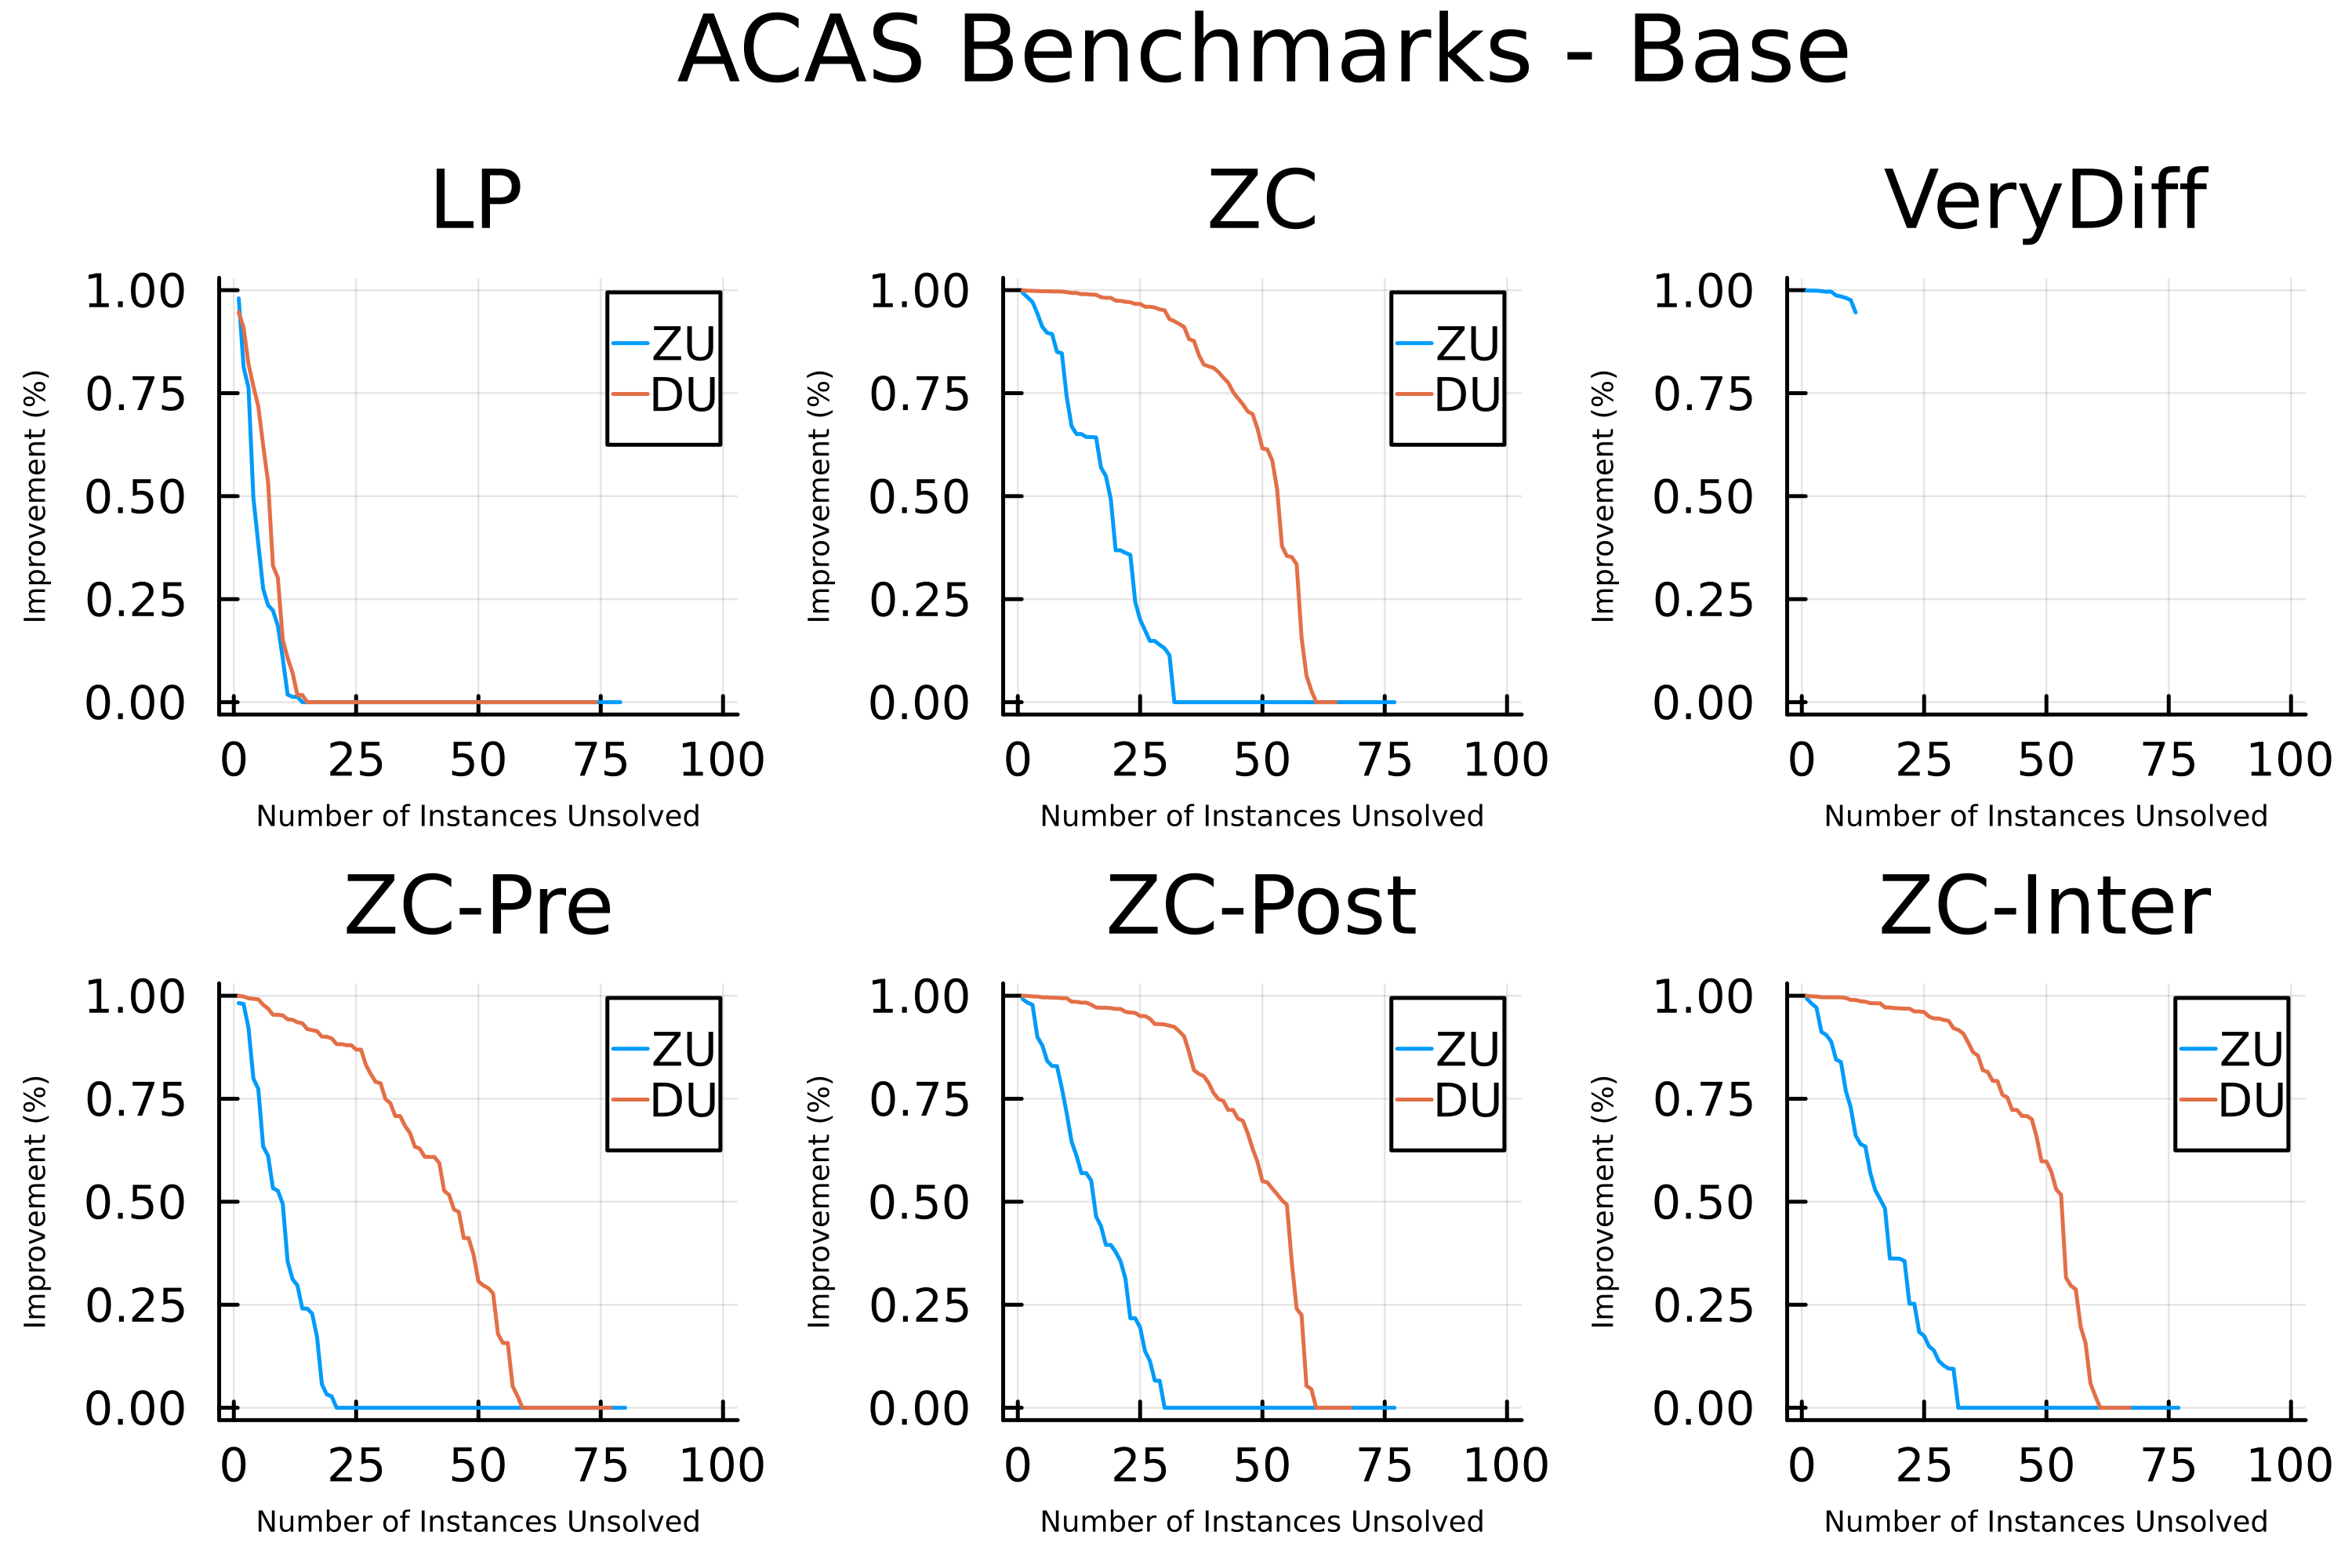

In [29]:
num_configs = size(base_configs, 1) + 1

p = plot(dpi=500, xlims=(0, 100), ylims=(0, 1), widen=true, xguidefontsize=5, yguidefontsize=5; layout=num_configs)
xlabel!("Number of Instances Unsolved")
ylabel!("Improvement (%)")

name, rgxs = verydiff_config
indices = filter_indices(acas_unsolved, rgxs)
plot!(p, x_acas_unsolved[indices], y_acas_unsolved[indices], title=name, label=nothing, subplot=3)

for (i, (name, rgxs)) in enumerate(base_configs)
    indices = filter_indices(acas_unsolved, rgxs)
    plot!(p, x_acas_unsolved[indices], y_acas_unsolved[indices], title=replace(name, "-Base" => ""), label=["ZU" "DU"], subplot=(i + i ÷ 3))
end

plot!(p, plot_title="ACAS Benchmarks - Base", plot_titlevspan=0.1)

savefig(p, "acas_benchmarks_unsolved_base.png")

p

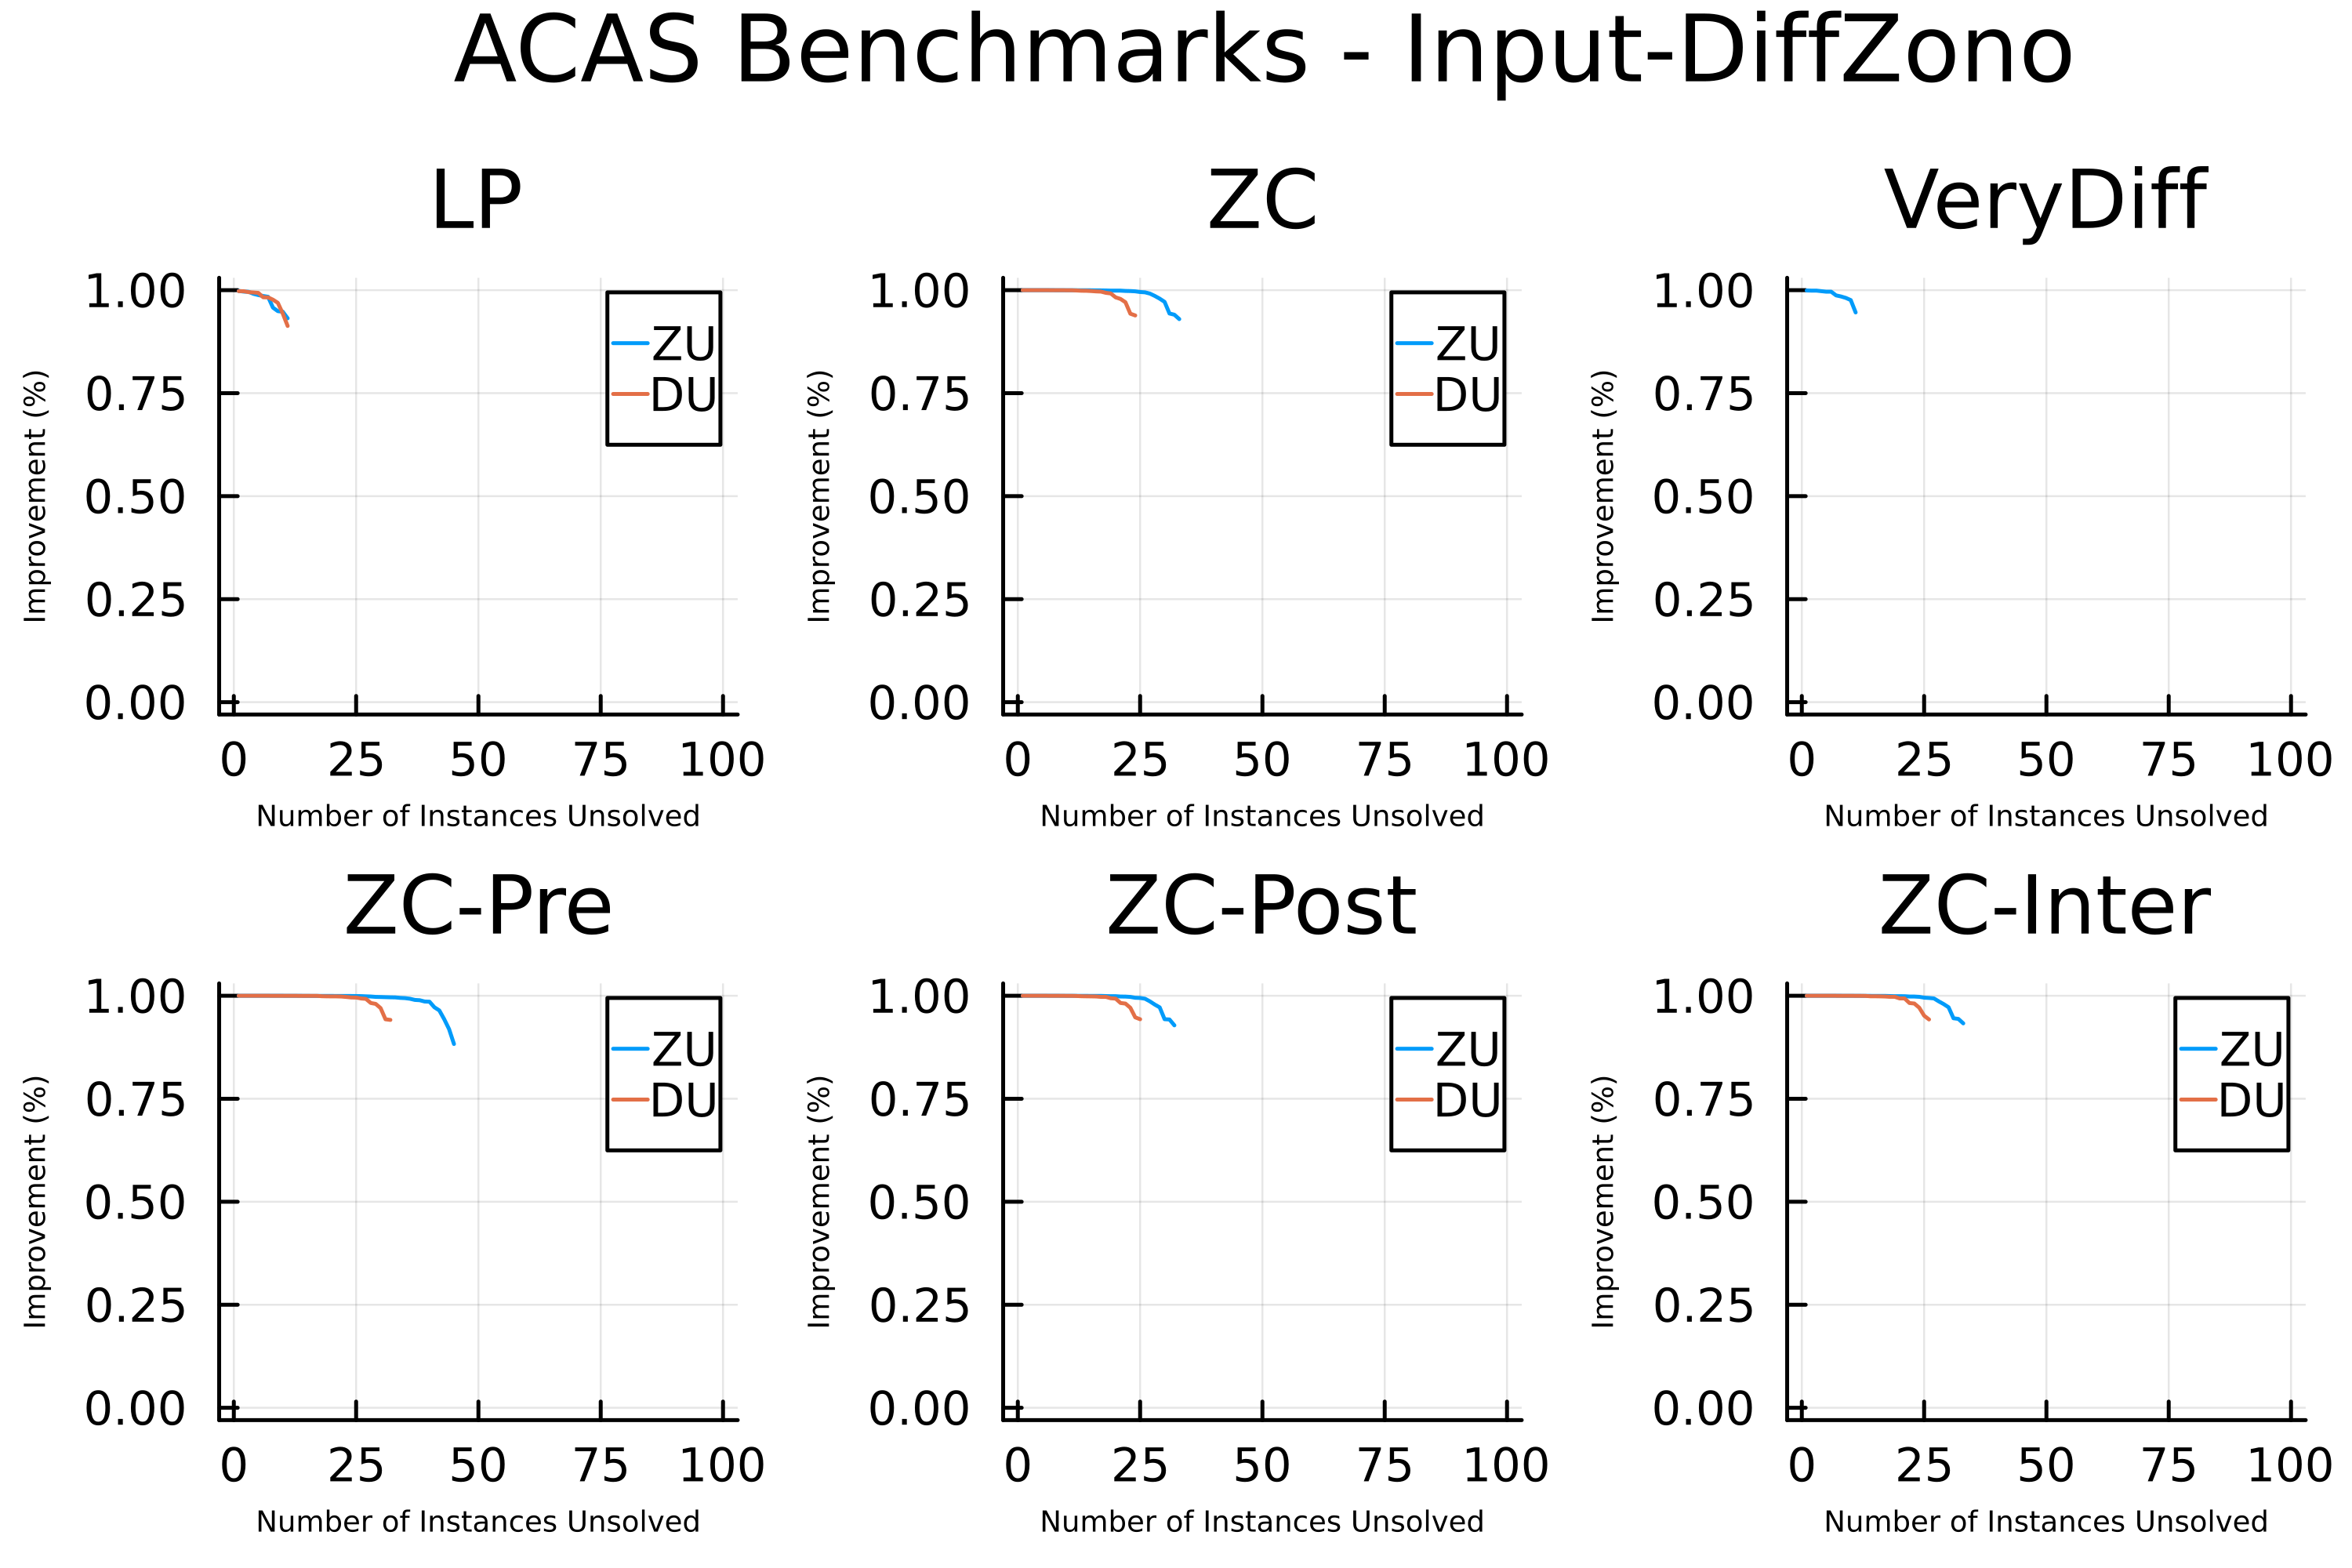

In [30]:
num_configs = size(input_diffzono_configs, 1) + 1

p = plot(dpi=500, xlims=(0, 100), ylims=(0, 1), widen=true, xguidefontsize=5, yguidefontsize=5; layout=num_configs)
xlabel!("Number of Instances Unsolved")
ylabel!("Improvement (%)")

name, rgxs = verydiff_config
indices = filter_indices(acas_unsolved, rgxs)
plot!(p, x_acas_unsolved[indices], y_acas_unsolved[indices], title=name, label=nothing, subplot=3)

for (i, (name, rgxs)) in enumerate(input_diffzono_configs)
    indices = filter_indices(acas_unsolved, rgxs)
    plot!(p, x_acas_unsolved[indices], y_acas_unsolved[indices], title=replace(name, "-Input-DiffZono" => ""), label=["ZU" "DU"], subplot=(i + i ÷ 3))
end

plot!(p, plot_title="ACAS Benchmarks - Input-DiffZono", plot_titlevspan=0.1)

savefig(p, "acas_benchmarks_unsolved_input_diffzono.png")

p